In [65]:
import subprocess
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
RUN = 67

In [67]:
# get stdout from a terminal command
def get_stdout(command):
    return subprocess.check_output(command, shell=True).decode('utf-8')

POD_TO_NODE = {}
def get_node_of_pod(podname):
    if podname in POD_TO_NODE:
        return POD_TO_NODE[podname]
    else:
        node = get_stdout("kubectl get pod " + podname + 
                   " -o jsonpath='{.spec.nodeName}'")
        POD_TO_NODE[podname] = node
        return node

In [68]:
logfilename = f"none_CPU_{RUN}"

with open(logfilename) as f:
    lines = f.readlines()
    
rows = []    
    
for line in lines:
    
    line_json = json.loads(line.strip())
    
    cpu_util = line_json["CPUUtilizations"]
    for podname in cpu_util.keys():
        if podname == "utils":
            continue
        rows.append({
            "time": float(line_json["time"])/10**9,
            "podname": podname,
            "service": podname.split("-")[0],
            "node": get_node_of_pod(podname),
            "cpu": float(cpu_util[podname]),
        })
        
df = pd.DataFrame(rows)
df["time"] = df["time"] - df["time"].min()
# df = df[df["time"] <= 30]

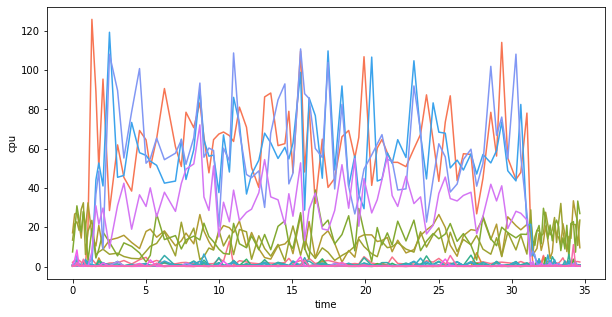

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.lineplot(ax=ax, data=df, x="time", y="cpu", hue="podname")

#remove legend from ax
ax.get_legend().remove()

In [70]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["podname", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,node,time,cpu
1,frontend-0,minikube-m04,14.548217,63.632592
14,profile-0,minikube-m03,14.548217,60.776180
15,profile-1,minikube-m03,14.548217,60.480545
17,recommendation-0,minikube-m02,14.548217,34.404639
6,hostagent-node3,minikube-m04,14.548217,14.734197
4,hostagent-node1,minikube-m02,14.548217,13.831531
5,hostagent-node2,minikube-m03,14.548217,10.329737
0,consul-0,minikube-m04,14.548217,2.307372
10,mongodb-profile-0,minikube-m03,14.548217,1.031188
12,mongodb-reservation-0,minikube-m03,14.548217,0.986712


In [71]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index().groupby("node").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,node,time,cpu
1,minikube-m03,112.032717,134.644565
2,minikube-m04,112.032717,82.367606
0,minikube-m02,112.032717,51.334280


In [72]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "service"]).mean().reset_index().groupby("service").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,service,time,cpu
6,profile,32.009348,121.255816
1,frontend,32.009348,63.976848
3,hostagent,48.014021,39.442057
8,recommendation,16.004674,34.033717
5,mongodb,80.023369,4.708250
0,consul,16.004674,2.273206
4,memcached,32.009348,0.704863
9,reservation,16.004674,0.481147
11,user,16.004674,0.416328
7,rate,16.004674,0.397242


In [73]:
df_grouped = df[df["time"] < 1].groupby("podname").mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,time,cpu
4,hostagent-node1,0.44228,22.068567
6,hostagent-node3,0.44228,20.905193
5,hostagent-node2,0.44228,20.584666
0,consul-0,0.44228,2.519103
18,reservation-0,0.44228,2.094025
10,mongodb-profile-0,0.44228,1.566259
13,mongodb-user-0,0.44228,1.244417
15,profile-1,0.44228,1.216973
11,mongodb-rate-0,0.44228,1.113007
12,mongodb-reservation-0,0.44228,1.082515
